# Modeling

**Imports**

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# imports for modeling
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# for knn
from sklearn.neighbors import KNeighborsClassifier

# for decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# for random forest
from sklearn.ensemble import RandomForestClassifier

# for logistic regression
from sklearn.linear_model import LogisticRegression

# system import to access file on different directory 
import sys
sys.path.append("/Users/migashane/CodeUp/Data_Science/telco_churn_classification_project/util_")
import prepare_
import knn_model_


**Get data**

In [2]:
# get the fully cleaned data with dummies
telco = prepare_.final_prep_telco()

# split data into train, validate and test
train, validate, test = prepare_.split_data_(df=telco,
                     test_size=0.2, 
                     validate_size=0.2,
                    stratify_col="churn",
                    random_state=95)

# look at the different splits
train.shape, validate.shape, test.shape

((4225, 77), (1409, 77), (1409, 77))

In [3]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support_no_internet_service,streaming_tv_no_internet_service,streaming_movies_no_internet_service,contract_type_one_year,contract_type_two_year,internet_service_type_fiber_optic,payment_type_bank_transfer_(automatic),payment_type_credit_card_(automatic),payment_type_electronic_check,payment_type_mailed_check
2872,4091-TVOCN,Male,0,No,Yes,48,Yes,Yes,Yes,No,...,0,0,0,1,0,0,0,1,0,0
1106,1618-CFHME,Female,0,No,No,2,Yes,Yes,No,No,...,0,0,0,0,0,1,0,0,1,0
2081,2988-GBIVW,Female,1,Yes,No,70,Yes,Yes,Yes,No,...,0,0,0,0,0,1,0,0,1,0
6880,9774-NRNAU,Male,1,Yes,No,27,Yes,Yes,No,Yes,...,0,0,0,0,0,0,1,0,0,0
6205,8777-PVYGU,Female,0,Yes,No,52,Yes,No,Yes,No,...,0,0,0,1,0,0,0,0,0,1


Create models to predict churn based on internet type, monthly charges, tenure,contract type, parter and depenents.

**Separate features and target**

In [4]:
# features to pass to my model
features = ["internet_service_type_none", "internet_service_type_fiber optic", 
            "internet_service_type_dsl", "monthly_charges", "tenure", "contract_type_one year",
           "contract_type_two year", "contract_type_month_to_month", "phone_service_no", "phone_service_yes",
           "paperless_billing_no", "paperless_billing_yes", "tech_support_no", "tech_support_yes", "tech_support_no_internet_service"]

# the internet type feature dummy columns for modeling for training
xtrain = train[features]
ytrain = train.churn

# the internet type feature dummy columns for modeling for validation
xvalidate = validate[features]
yvalidate = validate.churn

# the internet type feature dummy columns for modeling for testing
xTest = test[features]
yTest = test.churn

xtrain.head(3)

,internet_service_type_none,internet_service_type_fiber optic,internet_service_type_dsl,monthly_charges,tenure,contract_type_one year,contract_type_two year,contract_type_month_to_month,phone_service_no,phone_service_yes,paperless_billing_no,paperless_billing_yes,tech_support_no,tech_support_yes,tech_support_no_internet_service
2872,0,0,1,78.75,48,1,0,0,0,1,0,1,1,0,0
1106,0,1,0,75.90,2,0,0,1,0,1,0,1,1,0,0
2081,0,1,0,90.85,70,0,0,1,0,1,0,1,1,0,0


**Baseline Accuracy**

In [5]:
accuracy_score(train.churn, train.baseline)

0.7346745562130178

### KNN

**Train KNN model on different k values**

In [6]:
# the maximun number of neighbors the model should look at
# in my case it can only look at 1% of the data
k_neighbors = math.ceil(len(train) * 0.01)

# the final result metric
metrics = []

for k in range(1, k_neighbors + 1):
#      baseline accuary
    train_baseline_acc_score = accuracy_score(train.churn, train.baseline)
    
    # create a knn object
    #                          n_neighborsint(default=5) 
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform', p=2)
    #                                                        p=1 uses the manhattan distance

    # fit training data to the object
    knn = knn.fit(xtrain, ytrain)
    
    #USE the thing
    train_score= knn.score(xtrain, ytrain)
    validate_score = knn.score(xvalidate, yvalidate)
    
    # create a dictionary of scores
    output = {
        "k": k,
        "train_score": train_score,
         "validate_score": validate_score,
        "difference": train_score - validate_score,
        "train_baseline_diff": train_baseline_acc_score - train_score,
        "validate_baseline_diff": train_baseline_acc_score - validate_score,
        "baseline_accuracy": train_baseline_acc_score,
    }
    
    metrics.append(output)

In [7]:
# get the result as a dataframe
model_df = pd.DataFrame(metrics)
model_df.head()

,k,train_score,validate_score,difference,train_baseline_diff,validate_baseline_diff,baseline_accuracy
0,1,0.990296,0.727466,0.262830,-0.255621,0.007208,0.734675
1,2,0.872899,0.767921,0.104979,-0.138225,-0.033246,0.734675
2,3,0.866982,0.755145,0.111837,-0.132308,-0.020471,0.734675
3,4,0.842840,0.775018,0.067822,-0.108166,-0.040343,0.734675
4,5,0.838107,0.769340,0.068767,-0.103432,-0.034665,0.734675


**Visualize my models**

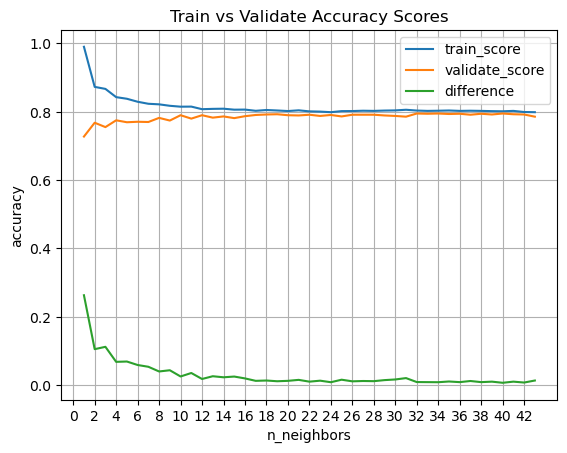

In [8]:

#PLOT train vs validate
model_df[model_df.columns[:-3]].set_index("k").plot()
plt.xticks(np.arange(0,44, 2))
plt.ylabel('accuracy')
plt.xlabel('n_neighbors')
plt.title("Train vs Validate Accuracy Scores")
plt.grid()
plt.show()

**Best KNN model**

In [9]:
# find the model with smallest ifference between the train and validate
model_df[model_df.difference == abs(model_df.difference).min()]

,k,train_score,validate_score,difference,train_baseline_diff,validate_baseline_diff,baseline_accuracy
39,40,0.80142,0.79489,0.00653,-0.066746,-0.060215,0.734675


### Decision tree

**Train decision tree model on different tree depth**

In [10]:
metrics = []
for d in range(1,11):
#     base line
    train_baseline_acc_score = accuracy_score(train.churn, train.baseline)

#      create tree object
    treeClf = DecisionTreeClassifier(max_depth= d, random_state=95)
    
    # fit model
    treeClf = treeClf.fit(xtrain, ytrain)
    
    # train accurecy score
    train_score = treeClf.score(xtrain, ytrain)
    validate_score = treeClf.score(xvalidate, yvalidate)
    
    # create a dictionary of scores
    output = {
        "depth": d,
        "train_score": train_score,
         "validate_score": validate_score,
        "difference": train_score - validate_score,
        "train_baseline_diff": train_baseline_acc_score - train_score,
        "validate_baseline_diff": train_baseline_acc_score - validate_score,
        "baseline_accuracy": train_baseline_acc_score,
    }
    
    metrics.append(output)

In [11]:
# get the result as a dataframe
model_df = pd.DataFrame(metrics)
model_df.head()

,depth,train_score,validate_score,difference,train_baseline_diff,validate_baseline_diff,baseline_accuracy
0,1,0.734675,0.734564,0.000111,0.000000,0.000111,0.734675
1,2,0.761183,0.758694,0.002489,-0.026509,-0.024020,0.734675
2,3,0.795266,0.785664,0.009603,-0.060592,-0.050989,0.734675
3,4,0.802130,0.784954,0.017176,-0.067456,-0.050279,0.734675
4,5,0.808994,0.784244,0.024750,-0.074320,-0.049570,0.734675


**Visualize my models**

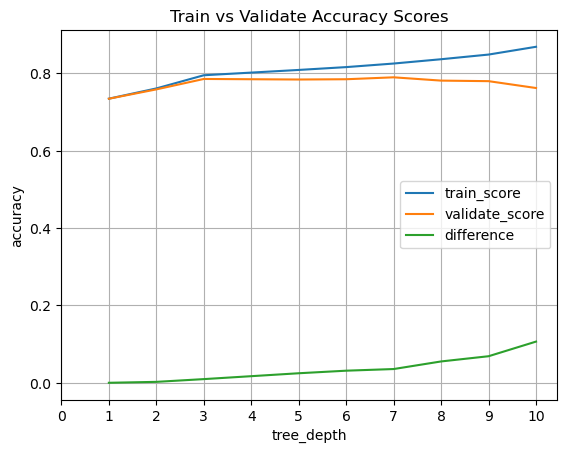

In [12]:
model_df[model_df.columns[:-3]].set_index("depth").plot()
plt.ylabel('accuracy')
plt.xlabel('tree_depth')
plt.title("Train vs Validate Accuracy Scores")
plt.xticks(np.arange(0,11))
plt.grid()
plt.show()

**Best decision tree model**

In [13]:
# find the model with smallest ifference between the train and validate
high_models = model_df[model_df.validate_score > model_df.baseline_accuracy + 0.05]

high_models[high_models.difference == abs(high_models.difference).min()]


,depth,train_score,validate_score,difference,train_baseline_diff,validate_baseline_diff,baseline_accuracy
2,3,0.795266,0.785664,0.009603,-0.060592,-0.050989,0.734675


### Random forest

**Train random forest model on different tree depth**

In [14]:
metrics = []

for trees in range(2,20):
     # base line
    train_baseline_acc_score = accuracy_score(train.churn, train.baseline)
    
    # create ramdom tree object
    randFor = RandomForestClassifier(n_estimators= 100, min_samples_leaf= trees, max_depth = trees, random_state=95 )
    
    # fit the model
    randFor = randFor.fit(xtrain, ytrain)
    
    # get accuracy scores
    train_score = randFor.score(xtrain, ytrain)
    validate_score = randFor.score(xvalidate, yvalidate)
    
    # create a dictionary of scores
    output = {
        "trees": trees,
        "train_score": train_score,
         "validate_score": validate_score,
        "difference": train_score - validate_score,
        "train_baseline_diff": train_baseline_acc_score - train_score,
        "validate_baseline_diff": train_baseline_acc_score - validate_score,
        "baseline_accuracy": train_baseline_acc_score,
    }
    
    metrics.append(output)

In [15]:
# get the result as a dataframe
model_df = pd.DataFrame(metrics)
model_df.head()

,trees,train_score,validate_score,difference,train_baseline_diff,validate_baseline_diff,baseline_accuracy
0,2,0.734675,0.734564,0.000111,0.000000,0.000111,0.734675
1,3,0.792426,0.781405,0.011021,-0.057751,-0.046731,0.734675
2,4,0.793136,0.785664,0.007473,-0.058462,-0.050989,0.734675
3,5,0.799763,0.792051,0.007712,-0.065089,-0.057377,0.734675
4,6,0.806864,0.796309,0.010554,-0.072189,-0.061635,0.734675


**Visualize my models**

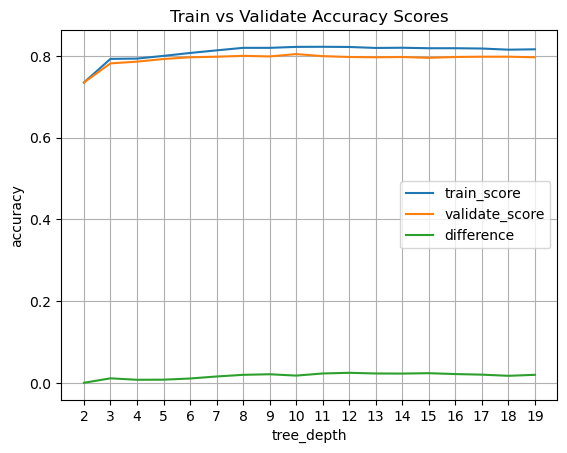

In [16]:
model_df[model_df.columns[:-3]].set_index("trees").plot()
plt.ylabel('accuracy')
plt.xlabel('tree_depth')
plt.title("Train vs Validate Accuracy Scores")
plt.xticks(np.arange(2,20))
plt.grid()
plt.show()

**Best random forest model**

In [17]:
# find the model with smallest ifference between the train and validate
high_models = model_df[model_df.validate_score > model_df.baseline_accuracy + 0.06]

high_models[high_models.difference == abs(high_models.difference).min()]


,trees,train_score,validate_score,difference,train_baseline_diff,validate_baseline_diff,baseline_accuracy
4,6,0.806864,0.796309,0.010554,-0.072189,-0.061635,0.734675


## Logistic regression

**Train logistic regression model on different C**

In [18]:
metrics = []

for c in np.arange(0.0001,0.1, 0.001):
     # base line
    train_baseline_acc_score = accuracy_score(train.churn, train.baseline)
    
    # create ramdom tree object
    logReg = LogisticRegression(C=c, random_state=95, max_iter= 1000)
    
    # fit the model
    randFor = logReg.fit(xtrain, ytrain)
    
    # get accuracy scores
    train_score = randFor.score(xtrain, ytrain)
    validate_score = randFor.score(xvalidate, yvalidate)
    
    # create a dictionary of scores
    output = {
        "C": c,
        "train_score": train_score,
         "validate_score": validate_score,
        "difference": train_score - validate_score,
        "train_baseline_diff": train_baseline_acc_score - train_score,
        "validate_baseline_diff": train_baseline_acc_score - validate_score,
        "baseline_accuracy": train_baseline_acc_score,
    }
    
    metrics.append(output)

In [19]:
# get the result as a dataframe
model_df = pd.DataFrame(metrics)
model_df

,C,train_score,validate_score,difference,train_baseline_diff,validate_baseline_diff,baseline_accuracy
0,0.0001,0.787929,0.784244,0.003685,-0.053254,-0.049570,0.734675
1,0.0011,0.789112,0.785664,0.003449,-0.054438,-0.050989,0.734675
2,0.0021,0.792899,0.786373,0.006526,-0.058225,-0.051699,0.734675
3,0.0031,0.796450,0.787083,0.009367,-0.061775,-0.052408,0.734675
4,0.0041,0.795503,0.786373,0.009130,-0.060828,-0.051699,0.734675
...,...,...,...,...,...,...,...
95,0.0951,0.799290,0.797019,0.002271,-0.064615,-0.062345,0.734675
96,0.0961,0.799290,0.796309,0.002981,-0.064615,-0.061635,0.734675
97,0.0971,0.799290,0.796309,0.002981,-0.064615,-0.061635,0.734675
98,0.0981,0.799290,0.796309,0.002981,-0.064615,-0.061635,0.734675


**Visualize my model**

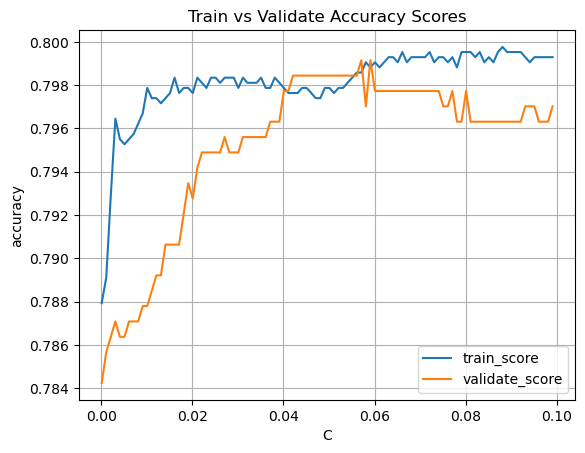

In [20]:
model_df[model_df.columns[:-4]].set_index("C").plot()
plt.ylabel('accuracy')
plt.xlabel('C')
plt.title("Train vs Validate Accuracy Scores")
plt.grid()
plt.show()

**Best logistic regression model**

In [21]:
# find the model with smallest ifference between the train and validate
high_models = model_df[(model_df.C > 0.045) & (model_df.C < 0.055)]

high_models[high_models.difference == high_models.difference.min()]


,C,train_score,validate_score,difference,train_baseline_diff,validate_baseline_diff,baseline_accuracy
47,0.0471,0.797396,0.798439,-0.001042,-0.062722,-0.063764,0.734675
48,0.0481,0.797396,0.798439,-0.001042,-0.062722,-0.063764,0.734675


### Test

I will test my result on my best model which is the random forest.


In [22]:
 # base line
train_baseline_acc_score = accuracy_score(train.churn, train.baseline)

# create ramdom tree object
logReg = LogisticRegression(C=0.0471, random_state=95, max_iter= 1000)

# fit the model
randFor = logReg.fit(xtrain, ytrain)

# pretict test
y_test_pred = logReg.predict(xTest)

# get prediction probability
y_test_pred_proba = logReg.predict_proba(xTest)

# get only probability of churn
churn_proba = []
for i in y_test_pred_proba:
    churn_proba.append(i[1])
    
# ouput for csv
output = {
    
    "customer_id": test.customer_id,
    "churn_proba": churn_proba,
    "prediction": y_test_pred
}

# # get accuracy scores
# train_score = randFor.score(xtrain, ytrain)
# validate_score = randFor.score(xvalidate, yvalidate)
# test_score = randFor.score(xTest, yTest)



In [27]:
# pandas dataframe to convert to csv
customer_predictions = pd.DataFrame(output)


# covert to csv
customer_predictions.to_csv("customer_prediction.csv", mode='w')